# Исследование данных сервиса аренды самокатов GoFast

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. 

Сервисом можно пользоваться:
- без подписки
 - абонентская плата отсутствует;
 - стоимость одной минуты поездки — 8 рублей;
 - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
 - абонентская плата — 199 рублей в месяц;
 - стоимость одной минуты поездки — 6 рублей;
 - стоимость старта — бесплатно.

***Описание данных***

В основных данных есть информация о пользователях, их поездках и подписках. Есть и дополнительная информация — о количестве обращений пользователей в техподдержку сервиса до и после обновления технической инфраструктуры.
- Пользователи — users_go.csv
- Поездки — rides_go.csv
- Подписки — subscriptions_go.csv

***Таблица users***

Хранит следующие данные о пользователях:

- user_id - идентификатор пользователя
- name - имя пользователя
- city - город
- subscription_type - тип подписки пользователя (бесплатная или платная)

***Таблица rides***

Имеет данные о поездках:

- user_id - идентификатор пользователя
- distance - дистанция поездки
- duration - продолжительность поездки
- date - дата поездки

***Таблица subscriptions***

Содержит лишь две строки с описанием подписок:

- subscription_type - тип подписки
- minute_price - стоимость минуты поездки 
- start_ride_price - стоимость старта
- subscription_fee - стоимость подписки

#### Шаг 1. Загрузка данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy import stats as st

Считываем файлы и сохраняем в переменные:

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

Посмотрим первые строки таблиц:

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.describe()

,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


In [7]:
subscriptions

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Шаг 2. Предобработка данных

##### Изменение типов данных

Посмотрим типы данных в таблицах:

In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [9]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [10]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Тип данных в столбце date таблицы rides необходимо изменить на тип datetime. В остальных столбцах типы соответствуют содержанию.

In [11]:
# Меняем тип данных с помощью метода pd.to_datetime() и указываем необходимый формат
rides['date'] = pd.to_datetime(rides['date'],format='%Y-%m-%d')
# Проверяем успешность вызовом .dtype
rides['date'].dtype

dtype('<M8[ns]')

***Итог:*** Изменили тип данных только в столбце date  на тип datetime

##### Дополнение данных

Добавим столбец с номером месяца в таблицу rides:

In [12]:
rides['month'] = rides['date'].dt.month

Проверим за какие годы у нас имеются данные:

In [13]:
rides['date'].dt.year.unique()

array([2021])

##### Работа с пропусками и дубликатами 

В разделе с изменением типов данных при вызове info() удалось установить, что в таблицах нет пропусков.

Изучим дубликаты по таблицам:

***users***

Так как датафрейм хранит данные о пользователях, то строки не должны повторяться, соответственно необходимо проверить наличие явных дубликатов. 

In [14]:
users.duplicated().sum()

31

Избавимся от дубликатов:

In [15]:
users = users.drop_duplicates()
users.duplicated().sum()

0

Есть вероятность, что есть неявные дубликаты в столбе с городом, нужно проверить:

In [16]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

Дубликатов нет, вероятно данные не заполнялись вручную. 

***rides***

В данной таблице могут быть только явные дубликаты, их и проверим:

In [17]:
rides.duplicated().sum()

0

***subscriptions***

Всего две строки с двумя типами подписок, проверка не требуется, по самой таблице видим отсутствие дубликатов.

***Итог:*** В результате предобработки избавились от явных дубликатов в таблице users, к дургим датасетам замечаний нет.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

Построим график по количеству городов в таблице users:

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64


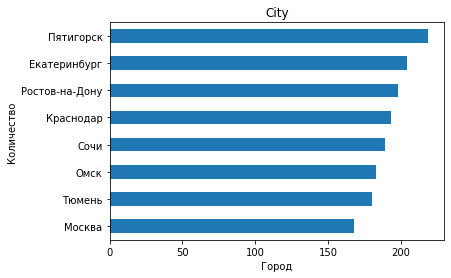

In [18]:
print(users.groupby('city')['city'].count().sort_values(ascending=False))
users.groupby('city')['city'].count().sort_values(ascending=False).plot(kind='barh');

plt.title('City')
plt.xlabel("Город")
plt.ylabel("Количество")
plt.gca().invert_yaxis ()

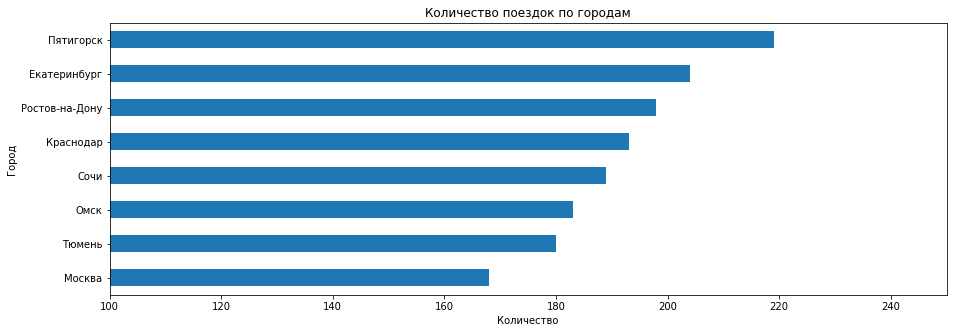

In [19]:
# Код ревьюера
users.groupby('city')['city'].count().sort_values().plot(kind='barh',
                                                                       figsize = (15, 5), 
                                                                       title = 'Количество поездок по городам')

plt.xlabel("Количество")
plt.ylabel("Город")
plt.xlim(100, 250)
plt.show()

В данных чаще всего встречаются пользователи из Пятигорска, а на последнем месте Москва. Также, хотел бы заметить, что разрыв между городами не столь велик. Достаточно много факторов могут повлиять на пользование самокатами по городам, например, количество отведенных мест для поездки, качество дорожного покрытия, популярность самокатов, плотность населения, которая влияет на удобство поездки. Я бы не стал придавать значение распределению по городам. 

##### Соотношение пользователей с подпиской и без подписки

Оценим количество пользователей с платной и бесплатной подпиской:

subscription_type
free     835
ultra    699
Name: subscription_type, dtype: int64


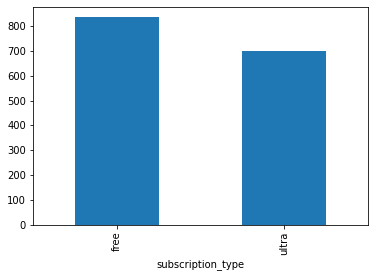

In [20]:
print(users.groupby('subscription_type')['subscription_type'].count())
users.groupby('subscription_type')['subscription_type'].count().plot(kind='bar');

In [21]:
free_n = users[users['subscription_type'] == 'free']['subscription_type'].count() / users['subscription_type'].count()
ultra_n = users[users['subscription_type'] == 'ultra']['subscription_type'].count() / users['subscription_type'].count()
print('Процент пользователей с бесплатной подпиской {:,%}'.format(free_n))
print('Процент пользователей с платной подпиской {:,%}'.format(ultra_n))

Процент пользователей с бесплатной подпиской 54.432855%
Процент пользователей с платной подпиской 45.567145%


По данным наблюдаем, что процент пользователей с бесплатной подпиской на 8 с лишним пунктов выше, что логично, не все готовы платить за подписку.

##### Возраст пользователей

Исследуем возраст пользователей самокатов:

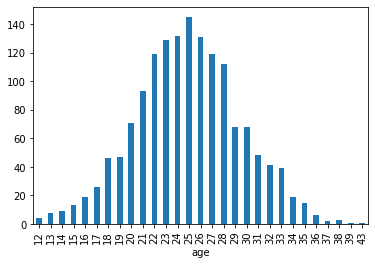

In [22]:
users.groupby('age')['age'].count().plot(kind='bar');

In [23]:
print('Средний возраст пользователя:', users['age'].mean().round(2))
print('Минимальный возрат пользователя:', users['age'].min())
print('Максимальный возраст пользователя:', users['age'].max())

Средний возраст пользователя: 24.9
Минимальный возрат пользователя: 12
Максимальный возраст пользователя: 43


По графику видим почти идеальное нормальное распределение с пиком в 25 лет, что подтверждает средний возраст пользователя, основной массой пользователей я бы назвал людей с возрастом от 18 до 33 лет. Минимальный и максимальный возраст пользователя составляет 12 лет и 43 года соответственно. 

##### Расстояние, которое пользователь преодолел за одну поездку

Посмотрим как распределяется расстояние поездок:

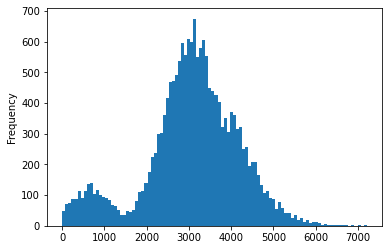

In [24]:
rides['distance'].plot(kind='hist', bins=100);

Большая часть данных находится в центре графика, как и ожидается, но также есть "пучок" слева, возможно это короткие прогулки, или пользователи использовали самокат, чтобы лишь добраться, допустим, до магазина.

(2500.0, 4000.0)

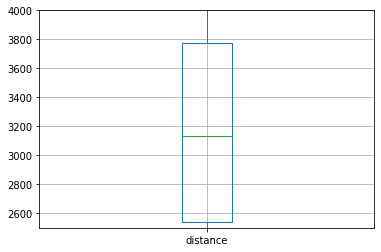

In [25]:
rides.boxplot('distance');
plt.ylim(2500, 4000)

Действительно, наблюдаем выбросы как сверху, так и снизу, причем снизу большое количество, получилась цельная линия из кружков.

##### Продолжительность поездок

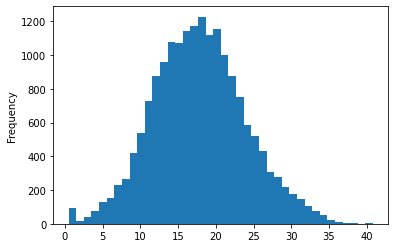

In [26]:
rides['duration'].plot(kind='hist', bins=40);

(10.0, 25.0)

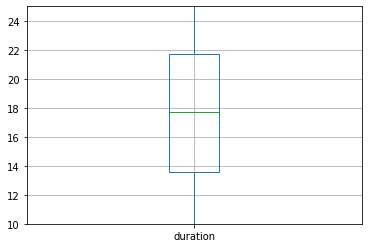

In [27]:
rides.boxplot('duration', );
plt.ylim(10, 25)

Наблюдаем похожий график на график расстояния, ведь это прямо зависимые показатели. Большая часть пользователей находятся в пути примерно от 13 до 22 минут

***Итог:*** В ходе исследования данных найдены некоторые факты о пользователях:

Лидером по количеству пользователей является Пятигорск, но разница между городами не велика. Процент пользователей с бесплатной подпиской выше примерно на 8%. В основном сервисом пользуются люди в возрасте примерно от 18 до 33 лет. Расстояние поездки стремиться ввысь около отметки в 3000 метров, однако присутствуют люди, которые предпочитают непродолжительные поездки примерно до 1 километра. Большая часть пользователей находятся в пути примерно от 13 до 22 минут.

#### Шаг 4. Объединение данных

##### Объединение данных

Создаем объединенный датафрейм. Так как таблица rides имеет данные о поездках и содержит больше строк именно к ней добавляем другие:

In [28]:
data = rides.merge(users, on='user_id', how='left')
data = data.merge(subscriptions, on='subscription_type', how='left')
pd.set_option('display.max_columns', None)
data.head(10)

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
5,1,2770.890808,16.650138,2021-10-09,10,Кира,22,Тюмень,ultra,6,0,199
6,1,3039.020292,14.927879,2021-10-19,10,Кира,22,Тюмень,ultra,6,0,199
7,1,2842.118050,23.117468,2021-11-06,11,Кира,22,Тюмень,ultra,6,0,199
8,1,3412.690668,15.238072,2021-11-14,11,Кира,22,Тюмень,ultra,6,0,199
9,1,748.690645,15.041884,2021-11-22,11,Кира,22,Тюмень,ultra,6,0,199


In [29]:
# Код ревьюера
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


##### Создание таблиц по категориям

Необходимо создать две таблицы для пользователей с бесплатной и платной подписками:

In [30]:
data_free = data.query('subscription_type == "free"')
data_free = data_free.reset_index(drop=True)
data_free.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


In [31]:
data_ultra = data.query('subscription_type == "ultra"')
data_ultra = data_ultra.reset_index(drop=True)
data_ultra.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


##### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

***data_free расстояние***

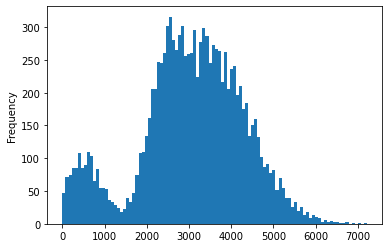

In [32]:
data_free['distance'].plot(kind='hist', bins=100);

Видим ту же картину, что и при общих данных, поведение пользователей с бесплатной подпиской не сильно отличается от общей информации.

***data_free время***

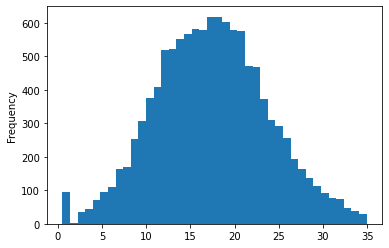

In [33]:
data_free['duration'].plot(kind='hist', bins=40);

И вновь есть значительное сходство с общими результатами.

Так же можем дополнительно продемонстрировать взаимосвязь с помощью графиков ниже:

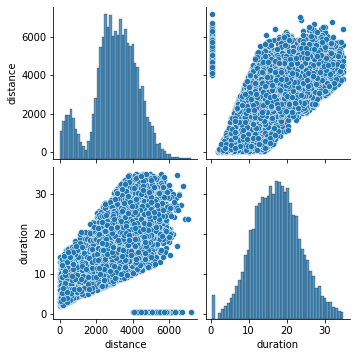

In [34]:
sns.pairplot(data_free[['distance', 'duration']]); 

***data_ultra расстояние***

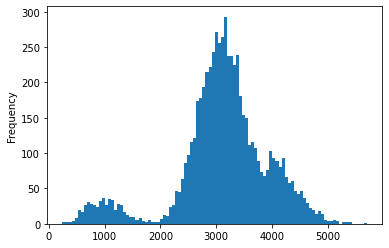

In [35]:
data_ultra['distance'].plot(kind='hist', bins=100);

Видим схожий график, однако показателей с меньшим расстоянием вдвое меньше, так как стоимость самой поездки меньше, то и желание проехать больше выше.

***data_ultra время***

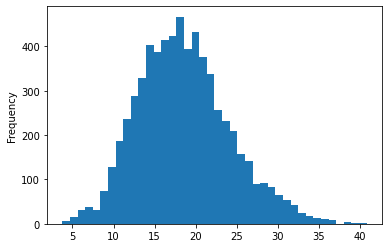

In [36]:
data_ultra['duration'].plot(kind='hist', bins=40);

Здесь графики тоже отличаются, уже нет такого заметного выброса на низком времени. Так же заметим, что максимальное количество времени выше. 

In [37]:
print('Максимальное время у пользователей с бесплатной подпиской:', data_free['duration'].max().round(2))
print('Максимальное время у пользователей с платной подпиской:', data_ultra['duration'].max().round(2))

Максимальное время у пользователей с бесплатной подпиской: 34.95
Максимальное время у пользователей с платной подпиской: 40.82


In [38]:
print('Максимальное расстояние у пользователей с бесплатной подпиской:', data_free['distance'].max().round(2))
print('Максимальное расстояние у пользователей с платной подпиской:', data_ultra['distance'].max().round(2))

Максимальное расстояние у пользователей с бесплатной подпиской: 7211.01
Максимальное расстояние у пользователей с платной подпиской: 5699.77


***Сравнение***

Для начала сравним общие показатели:

In [39]:
data_free[['distance', 'duration']].describe()

,distance,duration
count,11568.000000,11568.000000
mean,3045.495282,17.390909
std,1246.173806,6.326803
min,0.855683,0.500000
25%,2366.562689,12.958437
50%,3114.648465,17.326890
75%,3905.697894,21.594071
max,7211.007745,34.948498


In [40]:
data_ultra[['distance', 'duration']].describe()

,distance,duration
count,6500.000000,6500.000000
mean,3115.445388,18.541985
std,836.895330,5.572048
min,244.210438,3.760353
25%,2785.444017,14.524654
50%,3148.637229,18.178153
75%,3560.574425,21.884129
max,5699.769662,40.823963


Построим графики для сравнения:

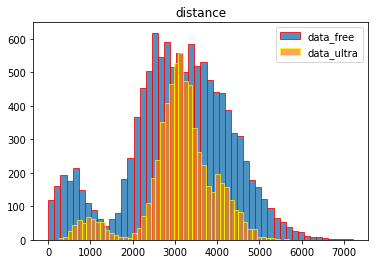

In [41]:
plt.hist(data_free['distance'], label='data_free', alpha=.8, edgecolor='red', bins=50)
plt.hist(data_ultra['distance'], label='data_ultra', alpha=0.7, edgecolor='yellow', bins=50)
plt.legend()
plt.title('distance')
plt.show()

Есть определенное сходство между графиками, однако разброс у пользователей с платной подпиской меньше, более централизовано около отметки в 3000.

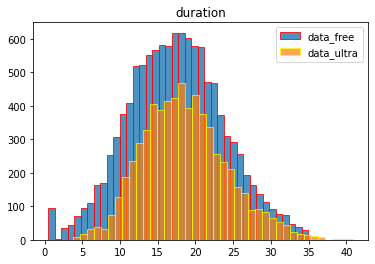

In [42]:
plt.hist(data_free['duration'], label='data_free', alpha=.8, edgecolor='red', bins=40)
plt.hist(data_ultra['duration'], label='data_ultra', alpha=0.7, edgecolor='yellow', bins=40)
plt.legend()
plt.title('duration')
plt.show()

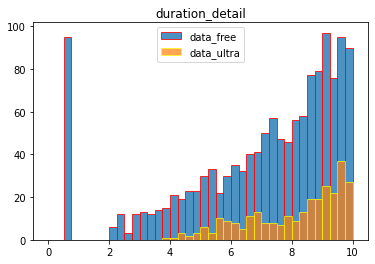

In [43]:
plt.hist(data_free['duration'], label='data_free', alpha=.8, edgecolor='red', bins=40, range=(0, 10))
plt.hist(data_ultra['duration'], label='data_ultra', alpha=0.7, edgecolor='yellow', bins=40, range=(0, 10))
plt.legend()
plt.title('duration_detail')
plt.show()

Так же видим сходство, но у пользователей с платной подпиской нет выброса где-то между 0 и 1, вероятнее всего это новые пользователи, которые лишь хотели попробовать данную услугу или же это пользователи, которые решили прокатиться до ближайшего пункта назначения.

#### Шаг 5. Подсчёт выручки

***Агрегирование данных о поездках***

Создадим новый датафрейм на основе общей таблице, которую ранее собрали:

In [44]:
data_agg = (data.groupby(by=(['user_id', 'month', 'name', 'age', 
                             'city', 'subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']))
            .agg({'distance':'sum', 'duration':'sum', 'date':'count'})
            .reset_index()
           )
data_agg = data_agg.rename(columns={'date':'count'})
data_agg.head()

,user_id,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,count
0,1,1,Кира,22,Тюмень,ultra,6,0,199,7027.511294,41.416640,2
1,1,4,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,1
2,1,8,Кира,22,Тюмень,ultra,6,0,199,6723.470560,44.776802,2
3,1,10,Кира,22,Тюмень,ultra,6,0,199,5809.911100,31.578017,2
4,1,11,Кира,22,Тюмень,ultra,6,0,199,7003.499363,53.397424,3


***Подсчет выручки***

Добавим столбец с выручкой по месяцам для каждого пользователя:

In [45]:
data_agg['revenue'] = (data_agg['start_ride_price'] * 
                       data_agg['count'] + data_agg['duration'].round() * 
                       data_agg['minute_price'] + data_agg['subscription_fee'])
data_agg.head()                                                            

,user_id,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,count,revenue
0,1,1,Кира,22,Тюмень,ultra,6,0,199,7027.511294,41.416640,2,445.0
1,1,4,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,1,235.0
2,1,8,Кира,22,Тюмень,ultra,6,0,199,6723.470560,44.776802,2,469.0
3,1,10,Кира,22,Тюмень,ultra,6,0,199,5809.911100,31.578017,2,391.0
4,1,11,Кира,22,Тюмень,ultra,6,0,199,7003.499363,53.397424,3,517.0


In [46]:
# Код ревьюера
data_agg.groupby('subscription_type')['revenue'].mean()

subscription_type
free     321.784054
ultra    358.538054
Name: revenue, dtype: float64

#### Шаг 6. Проверка гипотез

##### Время поездки

Необходимо выяснить тратят ли пользователи с платной подпиской больше времени на поездки. Сформулируем гипотезы:

- H₀ - Среднее время между пользователями с подписками "free" и "ultra" не различаются;
- H₁ - Среднее время пользователей "ultra" выше, чем у пользователей "free".

Для проверки гипотезы используем t-тест: 

In [47]:
# уровень статистической значимости
alpha = 0.05

results = st.ttest_ind(
    data_free['duration'],
    data_ultra['duration'],
    alternative='less'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Нулевая гипотеза не отвергнута")
       
print('Средннее время поездки у бесплатной подписки:', data_free['duration'].mean().round(2))
print('Средняее время поездки у платной подписки', data_ultra['duration'].mean().round(2))

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу
Средннее время поездки у бесплатной подписки: 17.39
Средняее время поездки у платной подписки 18.54


Так как данная гипотеза была сформирована для выяснения действительно ли пользователи с подпиской тратят больше времени и выгоднее для компании, то эту теорию подтверждаем исходя из полученных результатов.

##### Расстояние одной поездки

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Выясним проезжают ли пользователи с подпиской менее 3130 метров.

- H₀ - Среднее расстояние у пользователей с платной подпиской за одну поездку равно 3130 метров;
- H₁ - Среднее расстояние у пользователей с платной подпиской за одну поездку меньше 3130 метров.

In [48]:
value = 3130
alpha = 0.05

results = st.ttest_1samp(data_ultra['distance'], value, alternative='less')

print('p-значение:', results.pvalue) 

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: средняя дистанция поездки меньше 3130 метров')
else:
    print('Не получилось отвергнуть нулевую гипотезу: средняя дистанция поездки в пределах оптимального')
    
print('Средняя дистанция поездки:', data_ultra['distance'].mean().round(2))    

p-значение: 0.08046311521502146
Не получилось отвергнуть нулевую гипотезу: средняя дистанция поездки в пределах оптимального
Средняя дистанция поездки: 3115.45


Делаем вывод, что самокаты в безопасности и чаще проезжают оптимальное расстояние.

##### Выручка пользователей с платной и бесплатной подписками

Необходимо выяснить больше ли выручка у пользователей с платной подпиской, чем у пользователей с бесплатной. Для проверки выведем следующие гипотезы: 

- H₀ - Средняя выручка у пользователей с платной и бесплатной подписками равны;
- H₁ - Средняя выручка у пользователей с платной подпиской больше, чем у пользователей с бесплатной.

In [49]:
free = data_agg.query('subscription_type == "free"')
ultra = data_agg.query('subscription_type == "ultra"')

alpha = 0.05

results = st.ttest_ind(free['revenue'], ultra['revenue'], alternative='less')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
       
print('Средняя выручка в месяц у пользователей с бесплатной подпиской:', free['revenue'].mean().round(2))
print('Средняя выручка в месяц у пользователей с платной подпиской:', ultra['revenue'].mean().round(2))

p-значение: 2.3546897309064956e-37
Отвергаем нулевую гипотезу
Средняя выручка в месяц у пользователей с бесплатной подпиской: 321.78
Средняя выручка в месяц у пользователей с платной подпиской: 358.54


Делаем вывод, что пользователи с платной подпиской приносят больше выручки компании, соответственно маркетинг лучше ориентировать на пользование услугой с подпиской.

##### Обновление сервера

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

***Ответ:*** Для решения потребуется тест на равенство средних для зависимых выборок, до и после изменений. 

При самом решении также задается уровень статистической значимости и используется метод st.ttest_rel(), которому передаются два аргумента: набор данных до изменений и после изменений. Далее полученное p-значение этого метода сравнивается с уровнем статистической значимости. Пример кода:

alpha = 0.05 

results = st.ttest_rel(before, after)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:

    print('Отвергаем нулевую гипотезу')
    
else:

    print('Не получилось отвергнуть нулевую гипотезу')

#### Итоги исследования

1. ***Исследовательский анализ данных***

   В ходе проведенного исследования данных удалось установить следующие выводы:

   1.1 ***Распределение по городам***
    
     Количество пользователей по городам:
    
     - Пятигорск - 219;
     - Екатеринбург - 204;
     - Ростов-на-Дону - 198;
     - Краснодар - 193;
     - Сочи - 189;
     - Омск - 183;
     - Тюмень - 180;
     - Москва - 168.
    
    В данных чаще всего встречаются пользователи из Пятигорска, а на последнем месте Москва. Также, хотел бы заметить, что разрыв между городами не столь велик. Достаточно много факторов могут повлиять на пользование самокатами по городам, например, количество отведенных мест для поездки, качество дорожного покрытия, популярность самокатов, степень "вхождения" бизнеса в город (от степени может зависеть количество самокатов), плотность населения, которая влияет на удобство поездки. Я бы не стал придавать значение распределению по городам.
    
    1.2 ***Соотношение пользователей с подпиской и без***
    
    По подсчетам имеющихся данных выведены следующие показатели:
    
    - Процент пользователей с бесплатной подпиской - 54.43%;
    - Процент пользователей с платной подпиской - 45.57%.
    
    Наиболее распространены пользователи с бесплатной подпиской. При оценке показателя стоит учитывать, что не все готовы платить за подписку, например, ввиду редкого использования (платная подписка может оказаться не выгодной), некоторые пользователи могли лишь попробовать услугу аренды самоката, а для этого дополнительная плата за подписку не нужна.
    
    1.3 ***Возраст пользователей***
    
    - Средний возраст пользователя - 24.9;
    - Минимальный возраст пользователя - 12;
    - Максимальный возраст пользователя - 43.
    
    График распределения практически идеально нормальный. Падение с уменьшением возраста может быть связано с личными денежными средствами пользователя, не все пользователи с возрастов в 12 лет могут счесть нужным платить за данную необязательную услугу, не говоря уже о мнении родителей. Падение с увеличением возраста может быть связано с меньшей популярностью, ведь поездки на самокатах все же развлечение не для людей в средних годах.  
    
    1.4 ***Расстояние, преодоленное за одну поездку***
    
    Большая часть данных находится в центре графика, как и ожидается, но так же есть "пучок" слева, возможно это короткие прогулки, или пользователи использовали самокат, чтобы лишь добраться, допустим, до магазина. Основная масса пользователей преодолевают расстояние примерно от 2500 метров до 3800 метров.
    
    1.5 ***Время поездки***
    
    Распределение схоже с распределением расстояние, что неудивительно, так как это созависимые показатели. Большая часть пользователей находятся в пути примерно от 13 до 22 минут

2. ***Исследовательский анализ данных в разрезе категорий***

   Пользователей разделили на тех, которые пользуются платной подпиской и бесплатной.
   
   В целом при оценке распределения показателей времени и расстояния наблюдаем похожие данные на общие, однако можем выявить следующие исключения:
   
   - Пользователи с платной подпиской чаще преодолевают более длительные дистанции, выброс на расстоянии примерно до 2000 метров вдвое ниже по сравнению с показателями пользователей с бесплатной подпиской;
   - Пользователи с платной подпиской так же совершают более длительные поездки, нет выброса на низких показателя как в случае с бесплатной подпиской;
   - Максимальное время у пользователей с платной подпиской выше:
    - Максимальное время у пользователей с бесплатной подпиской - 34.95;
    - Максимальное время у пользователей с платной подпиской - 40.82.
   - Но при этом максимальное расстояние выше у пользователей с бесплатной подпиской:
    - Максимальное расстояние у пользователей с бесплатной подпиской - 7211.01;
    - Максимальное расстояние у пользователей с платной подпиской - 5699.77.
    
   Поэтому можем сделать вывод, что пользователи с платной подпиской наиболее расположены к совершению прогулочных поездок. 
   
3. ***Проверка гипотез***
   
   3.1 ***Время поездки***
   
   Выдвинуты следующие гипотезы:
   
   - H₀ - Среднее время между пользователями с подписками "free" и "ultra" не различаются;
   - H₁ - Среднее время между пользователями с подписками "free" и "ultra" различаются.
   
   В ходе проверки нулевая гипотеза была опровергнута. Пользователи с платной подпиской тратят больше времени на поездки, соответственно, приносят больше прибыль компании.
   
   3.2 ***Расстояние одной поездки***
   
   Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Для проверки подвержены ли самокаты преждевременному износу сформулированы следующие гипотезы:
   
   - H₀ - Среднее расстояние у пользователей с платной подпиской за одну поездку равно 3130 метров;
   - H₁ - Среднее расстояние у пользователей с платной подпиской за одну поездку меньше 3130 метров.
   
   Проверив данные, нулевая гипотеза была опровергнута, чаще пользователи проезжают расстояние в пределах оптимального. 
   
   3.3 ***Выручка пользователей с платной и бесплатной подписками***
   
   Необходимо было выяснить больше ли выручка у пользователей с платной подпиской, чем у пользователей с бесплатной. Для проверки вывели следующие гипотезы:

   - H₀ - Средняя выручка у пользователей с платной и бесплатной подписками равны ;
   - H₁ - Средняя выручка у пользователей с платной и бесплатной подписками не равны.
   
   Нулевая гипотеза была опровергнута. Пользователи с платной подпиской приносят больше выручки компании, соответственно маркетинг лучше ориентировать на пользование услугой с подпиской. Однако, следует заметить, что показатели не так информативны, как чистая прибыль. Для получения более точных выводов анализ лучше построить на выручке с вычетом издержек (возможны следующие варианты: если у платной подписки есть большая поддержка пользователей, соответственно, дополнительные расходы на сотрудников; на привлечение пользователей с платной подпиской могли выделить дополнительные средства на рекламу; запустить контекстную рекламу и тому подобное).